In [70]:
using PyCall
using PyPlot
using Distributions
using LinearAlgebra
using BlockArrays
using DelimitedFiles 
include("tripole.jl")

gaussian (generic function with 1 method)

# Input parameters used to compute the chain


In [71]:
λ = 0.75 # Square root of the Huang-Rhys factor
hw_vibr = 0.19375*1 #vibrational energy

γ = 0.026 #0.0969*1.2 # HWHM of the lorentzian shape function OR standard deviation of a gaussian dynamic disorder
dz = 3.4 # distance between monomers in the chain in Angstrom
delz = 0.4 # taken from Saikin, accounts for an effective overlap of the wavefunctions
trp_fac= 4.1 # 4.7 tripole interaction multiplicative factor (influences q^2, where q is the tripole charge)
neighbors = 3 # number of neighbors in the chain
θ = 28 #rotation angle in degrees
Mers = 30 #number of monomers in the chain

Merschain = 1:Mers #iterable object useful for the chain indexing 

D=2 #number of orthogonal degenerate states
n_vib= 5 #how many basis function in the target displaced oscillator you want to approximate, 5 give convergence to actual spectrum

coupling = false
#randomization parameters
σ = hw_vibr*0.6*0.0001 #static noise  0.08075
σ_conv = hw_vibr*0.58 #convolution for quick estimation of disorder effect, equivalent to no correlation and usable only for small sigma
D_shift = 0.36 # gas-to-crystal shift
hw_00 = 2.681*1.005-D_shift
L0 =  70 #70  correlation length
;

 ## Generate the static disorder

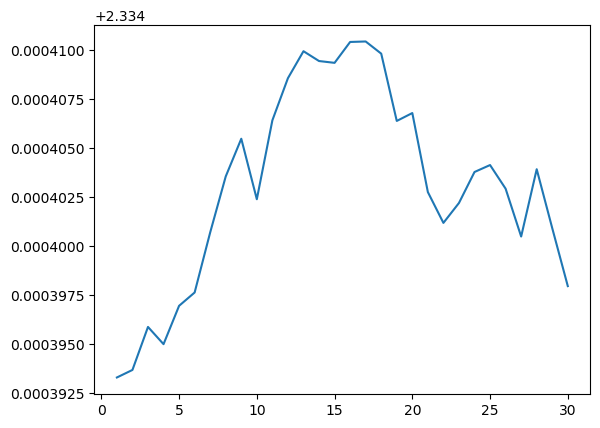

The correlation length is 70

In [72]:
μ_E = ones(Mers)*hw_00

if L0==0
    Distro_static = MvNormal(μ_E, σ)
    
    else
    Pos_M = zeros(Mers, Mers ) # initialize a Mers x Mers matrix that will contain the relative positions btw the monomers
    
    for i ∈ Merschain
        Pos_M[i, :] = abs.( Merschain .- i) # every monomer is distant 0 monomers with itself 
    end
    Var_M = exp.(-Pos_M/L0)*(σ^2)
    Distro_static = MvNormal(μ_E, Var_M)
    
        
    
end




print("The correlation length is " , L0)
En_pos = rand(Distro_static)

Var_M = nothing #throw the covariance matrix and the distro in the trash
Distro_static = nothing 

plot(Merschain, En_pos, )
;

In [73]:
block_size = D * n_vib #gives the size of the monomer part of the hamiltonian

subblock_size = n_vib # allows you to work with the vibrational states

mat_size = block_size * Mers

mat_div = ones(Int8, Mers)*block_size #divide the matrix in 'Mers' blocks of size 'block_size'
block_div = ones(Int8, D)*subblock_size #divide the block into sub-blocks

Ham_M = BlockArray(zeros(mat_size, mat_size), mat_div, mat_div) #initialize the Hamiltonian

vib_vect = ( 0 : ( n_vib-1) ) .* hw_vibr #vector containing the vibrations
vib_vect =  repeat(vib_vect, D) # repeat the vector if you want to consider degenerate states 



Coupl_M = BlockArray(zeros(block_size, block_size), block_div, block_div) #initialize the coupling matrix
Coupl_Arr = zeros(neighbors, block_size, block_size)

#create the coupling matrix for the m-th neighbor, we make a block matrix
if coupling == true 
    FC_factor = FC_overlap_0K.(Array(0:(n_vib-1)), λ) #calculate the vector of Frank_Condon factors for each n
    FC_M = kron(FC_factor, FC_factor') # calculate the Frank-Condon Matrix
    for m in 1:neighbors
        Coupl_Block_same = trp_fac.*FC_M.*same_int(m*(dz-delz), m, (mod(m*θ+60,120)-60) ) #modulo is for symmetrization after a rotation of 120 degrees
        Coupl_Block_cross = trp_fac.*FC_M.*cross_int(m*(dz-delz), m,  (mod(m*θ+60,120)-60)) #the mod expression keeps θ btw -60 and 60
         
            for i in 1:D
                for j in 1:D
                    if i == j
                        setblock!(Coupl_M, Coupl_Block_same, i, i )
                    else
                        setblock!(Coupl_M, Coupl_Block_cross, i, j )
                    end
                end
            end
        #println(Coupl_M)
        Coupl_Arr[m,:,:] = Coupl_M #create a vector of coupling matrices for each neighbor
        
    end
end

Coupl_Arr[1,:,:]

10×10 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [74]:
#iterate now over the chain to write the complete hamiltonian, we split the cycle in two parts:
#the first up to Mers-neighbors monomers and then for the last monomers since they do not have m neighbors to the right
for i in 1:(Mers-neighbors)
    stat_M = Diagonal(ones(block_size)) .* En_pos[i]  .+ Diagonal(vib_vect) #write the energy of the excited monomers with the vibration present
    setblock!(Ham_M, stat_M, i, i) # set the diagonal blocks of the hamiltonian with the static energies
    
    for m in 1:neighbors
         setblock!(Ham_M, Coupl_Arr[m,:,:], i+m, i) #set the coupling to the m-th neighbor
         setblock!(Ham_M, Coupl_Arr[m,:,:], i, i+m)
    end

end

#here we consider the last monomers of the chain that lack at least one of the right neighbors
for i in (Mers-neighbors+1):Mers 
    stat_M = Diagonal(ones(block_size)) .* En_pos[i]  .+ Diagonal(vib_vect)
    setblock!(Ham_M, stat_M, i, i)
    
    for m in 1:(Mers-i)
         setblock!(Ham_M, Coupl_Arr[m,:,:], i+m, i)
         setblock!(Ham_M, Coupl_Arr[m,:,:], i, i+m)
    end
    
    
    
end


Ham_M = Array(Ham_M);


In [75]:
eig_En = eigvals(Ham_M)
eig_V = eigvecs(Ham_M) 

300×300 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

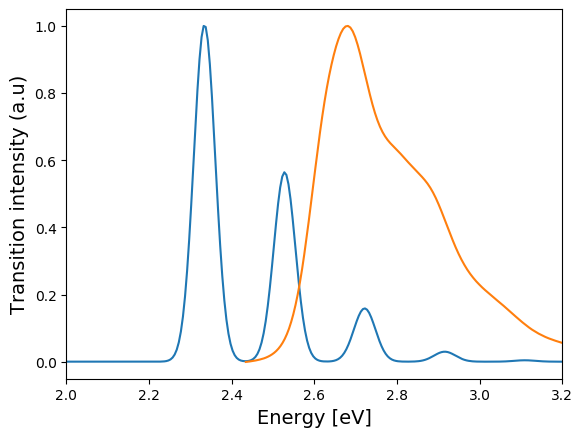

In [77]:
Peak_intens = (eig_V' * repeat(FC_factor, Mers*D)).^2  #calculate the intensity of each peak according to the Frank-Condon principle

x_size = 1000
x_intens = LinRange(0,5, x_size)
envelope = zeros(x_size)

for i in 1:mat_size
    
    envelope = envelope + gaussian.(x_intens, eig_En[i], γ )*Peak_intens[i]
    
end

envelope = envelope/maximum(envelope)

if coupling == false
    exp_data = readdlm("spectral_data/AbsTHF.dat", skipstart = 1)
    exp_label = "Experimental monomer data in THF"
    nothing
else
    exp_data = readdlm("spectral_data/AbsDod.dat", skipstart = 1)
    exp_label = "Experimental polymer data in "
    nothing
end

A = exp_data[:,2]
B = exp_data[:,1]
E= (c.*ħ./(B.*10^(-9)))./eV 
A = A./E

A =  A ./ maximum(A)

#load the experimental data

plot(x_intens, envelope, label = "OPA Holstein model")
plot(E, A, label = exp_label)
ylabel("Transition intensity (a.u)")
xlabel("Energy [eV]")
xlim(left = 2.0, right=3.2)
rc("axes", labelsize=14) 
